In [ ]:
# This handy piece of code changes Jupyter Notebooks margins to fit your screen.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Be sure you've installed the praw and tqdm libraries. If you haven't you can run the line below.  Node.js in required to install the jupyter widgets in a few cells.  These two cells can take a while to run and won't show progress; you can also run the commands in the command prompt (without the !) to see the progress as it installs.

If conda is taking a long time, you might try the mamba installer: https://github.com/TheSnakePit/mamba
`conda install -c conda-forge mamba -y`
Then installing packages with mamba should be done from the command line (console or terminal).

In [ ]:
!conda install tqdm praw nodejs -y

Install the jupyter widget to enable tqdm to work with jupyter lab:

In [ ]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

# Scrape Reddit Comments for a Sentiment Analysis - Assignment
### Go through the notebook and complete the code where prompted
##### This assignment was adapted from a number of sources including: http://www.storybench.org/how-to-scrape-reddit-with-python/ and https://towardsdatascience.com/scraping-reddit-data-1c0af3040768

In [4]:
# Import all the necessary libraries
import praw # Import the Praw library: https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html
import pandas as pd # Import Pandas library: https://pandas.pydata.org/
import datetime as dt # Import datetime library
import matplotlib.pyplot as plt # Import Matplot lib for plotting
from tqdm.notebook import tqdm  # progress bar used in loops

import credentials as cred  # make sure to enter your API credentials in the credentials.py file

# Prompt
### In the cell below, enter your client ID, client secret, user agent, username, and password in the appropitate place withing the quotation marks

In [5]:
reddit = praw.Reddit(client_id = 'A0HZsCKBk-P50g',
                     client_secret = '9vAJO7D2uhGh-I7wpVNDI2JEwm0',
                     username = 'baymsds', 
                     password = '2003@@PUujin', 
                     user_agent = 'msds')

# Prompt
## In the cell below, enter a subreddit you which to compare the sentiment of the post comments, decide how far back to pull posts, and how many posts to pull comments from.
## We will be comparing two subreddits, so think of a subject where a comparison might be interesting (e.g. if there are two sides to an issue which may show up in the sentiment analysis as positive and negative scores).

In [6]:
number_of_posts = 200
time_period = 'all'  # use posts from all time

# .top() can use the time_period argument
# subreddit = reddit.subreddit('').top(time_filter=time_period, limit=number_of_posts)

subreddit = reddit.subreddit('GlobalWarming').hot(limit=number_of_posts)

# Create an empty list to store the data
subreddit_comments = []

# go through each post in our subreddit and put the comment body and id in our dictionary
# the value for 'total' here needs to match 'limit' in reddit.subreddit().top()
for post in tqdm(subreddit, total=number_of_posts):
    submission = reddit.submission(id=post)
    submission.comments.replace_more(limit=0)  # This line of code expands the comments if “load more comments” and “continue this thread” links are encountered
    for top_level_comment in submission.comments: 
        subreddit_comments.append(top_level_comment.body)  # add the comment to our list of comments

In [7]:
# View the comments.
subreddit_comments

['Part 2 would probably go something like this. \n\n"Ok so he\'s ill, but the important thing is that it\'s not my fault"',
 'This is perfect and needs to be made into a film.',
 'This actually was well written and so much truth',
 "That's actually a wonderful allegory.  Thanks for posting!",
 'I love your writing',
 "       Hey, he might not actually be ill tho. There is still a chance he's not.\n       There is still a chance everyone is lying about climate change.",
 'Population decline has to be low, otherwise you get a rapidly aging population that can’t be supported by the productivity of the working people. Many western nations already have decreasing domestic populations that are supplemented with immigration, which isn’t good for the immigrant countries of origin like in Africa or Eastern Europe because the immigrants tend to be the people who can afford to move, which draws money, labor, and knowledge out of those nations.\n\nAlso if you reduced the population by half, you wo

In [8]:
# Store comments in a DataFrame using a dictionary as our input
# This sets the column name as the key of the dictionary, and the list of values as the values in the DataFrame
subreddit_comments_df = pd.DataFrame(data={'comment': subreddit_comments})
subreddit_comments_df

,comment
0,Part 2 would probably go something like this. ...
1,This is perfect and needs to be made into a film.
2,This actually was well written and so much truth
3,That's actually a wonderful allegory. Thanks ...
4,I love your writing
...,...
513,84° F in central Florida.
514,For everyone*
515,"Germany, a small city surrounded by mountains ..."
516,"12 celsius in thessaloniki, according to google."


In [9]:
# This is an example of how we split up the comments into individual words.
# This technique will be used again to get the scores of each individual word.
for comment in subreddit_comments_df['comment']:  # loop over each word
        comment_words = comment.split()  # split comments into individual words
        for word in comment_words:  # loop over idndividual words in each comment
            word = word.strip('?:!.,;"!@()#-')  # remove extraneous characters
            word = word.replace("\n", "")  # remove end of line
            print(word)
        
        break  # end the loop after one comment

Part
2
would
probably
go
something
like
this
Ok
so
he's
ill
but
the
important
thing
is
that
it's
not
my
fault


### Now we will use the sentiment file called AFINN-en-165.txt.  This file contains a sentiment score for 3382 words.  More information can be found here: https://github.com/fnielsen/afinn With the sentiment file we will assign scores to words within the top comments that are found in the AFINN file

In [10]:
# We load the AFINN sentiment table into a Python dictionary

sentimentfile = open("AFINN-en-165.txt", "r")  # open sentiment file
scores = {}  # an empty dictionary
for line in sentimentfile:  # loop over each word / sentiment score
    word, score = line.split("\t")  # file is tab-delimited
    scores[word] = int(score)  # convert the scores to intergers
    
sentimentfile.close()

In [11]:
# print out the first 10 entries of the dictionary
counter = 0
for key, value in scores.items():
    print(key, ':', value)
    counter += 1
    if counter >= 10:
        break

abandon : -2
abandoned : -2
abandons : -2
abducted : -2
abduction : -2
abductions : -2
abhor : -3
abhorred : -3
abhorrent : -3
abhors : -3


In [12]:
# we create a dictionary for storing overall counts of sentiment values
sentiments = {"-5": 0, "-4": 0, "-3": 0, "-2": 0, "-1": 0, "0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0}

for word in subreddit_comments_df['comment']:  # loop over each word
        comment_words = word.split()  # split comments into individual words
        for word in comment_words:  # loop over individual words in each comment
            word = word.strip('?:!.,;"!@()#-')  # remove extraneous characters
            word = word.replace("\n", "")  # remove end of line
            if word in scores.keys():  # check if word is in sentiment dictionary
                score = scores[word]  # check if word is in sentiment dictionary
                sentiments[str(score)] += 1  # add one to the sentiment score

In [13]:
# Print the scores
for sentiment_value in range(-5, 6):
    # this uses string formatting, more on this here: https://realpython.com/python-f-strings/
    print(f"{sentiment_value} sentiment:", sentiments[str(sentiment_value)])
    
# this would be equivalent, but obviously much less compact and elegant
# print("-5 sentiments ", sentiments["-5"])
# print("-4 sentiments ", sentiments["-4"])
# print("-3 sentiments ", sentiments["-3"])
# print("-2 sentiments ", sentiments["-2"])
# print("-1 sentiments ", sentiments["-1"])
# print(" 0 sentiments ", sentiments["0"])
# print(" 1 sentiments ", sentiments["1"])
# print(" 2 sentiments ", sentiments["2"])
# print(" 3 sentiments ", sentiments["3"])
# print(" 4 sentiments ", sentiments["4"])
# print(" 5 sentiments ", sentiments["5"])

-5 sentiment: 1
-4 sentiment: 34
-3 sentiment: 169
-2 sentiment: 353
-1 sentiment: 207
0 sentiment: 0
1 sentiment: 351
2 sentiment: 411
3 sentiment: 120
4 sentiment: 9
5 sentiment: 0


In [14]:
# Now let us put the sentiment scores into a dataframe.
comment_sentiment_df = pd.DataFrame(data={'Sentiment_Value': list(sentiments.keys()), 'Counts': list(sentiments.values())})
# the 'value' column is a string; convert to integer (numeric type)
comment_sentiment_df['Sentiment_Value'] = comment_sentiment_df['Sentiment_Value'].astype('int')

# We normalize the counts so we will be able to compare between two subreddits on the same plot easily
comment_sentiment_df['Normalized_Counts'] = comment_sentiment_df['Counts'] / comment_sentiment_df['Counts'].sum()  # Normalize the Count
comment_sentiment_df

,Sentiment_Value,Counts,Normalized_Counts
0,-5,1,0.000604
1,-4,34,0.020544
2,-3,169,0.102115
3,-2,353,0.213293
4,-1,207,0.125076
5,0,0,0.000000
6,1,351,0.212085
7,2,411,0.248338
8,3,120,0.072508
9,4,9,0.005438


# Prompt
## We will plot the data so it is easier to visualize.  
## In each of the three cells below, plot the Count, Normalized Count, and Normalized Score vs Sentiment Value.  In each plot add the appropriate x-label, y-label, plot title, and color

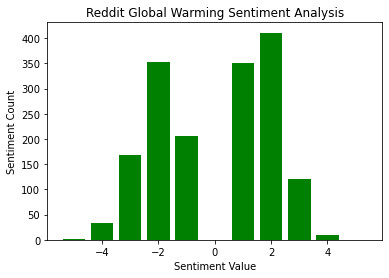

In [24]:
# Count vs Sentiment Value Plot
plt.bar(comment_sentiment_df['Sentiment_Value'], comment_sentiment_df['Counts'], color='green')  # add the y-values and color
plt.xlabel('Sentiment Value')  # add x-label
plt.ylabel('Sentiment Count')  # add y-label
plt.title('Reddit Global Warming Sentiment Analysis')  # add title
plt.show()

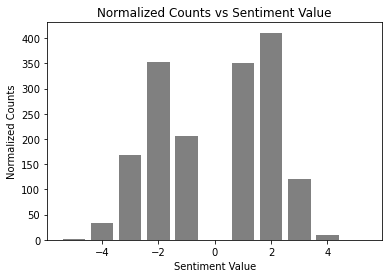

In [26]:
# Normalized Counts vs Sentiment Value Plot
plt.bar(comment_sentiment_df['Sentiment_Value'], comment_sentiment_df['Counts'], color='gray')  # add the y-values and color
plt.xlabel('Sentiment Value')  # add x-label
plt.ylabel('Normalized Counts')  # add y-label
plt.title('Normalized Counts vs Sentiment Value')  # add title
plt.show()

# Prompt
### In the cell below, enter a subreddit you which to compare the sentiment of the post comments, decide how far back to pull posts, and how many posts to pull comments from.

Pick a subreddit that can be compared with your first subreddit in terms of sentiment. You may want to go back up to the first subreddit section and change some parameters.  For example, do you want to find top posts, or hot posts? From what time period? How many posts?  If you change these settings above (the `number_of_posts` and `time_period` variables) you should re-run the notebook from the beginning.

The following code is the same as we did for our first subreddit, just condensed into one code cell.

In [27]:
subreddit_2 = reddit.subreddit('Futurology').hot(limit=number_of_posts)


# Create an empty list to store the data
subreddit_comments_2 = []

# go through each post in our subreddit and put the comment body and id in our dictionary
for post in tqdm(subreddit_2, total=number_of_posts):
    submission = reddit.submission(id=post)
    submission.comments.replace_more(limit=0)  # This line of code expands the comments if “load more comments” and “continue this thread” links are encountered
    for top_level_comment in submission.comments: 
        subreddit_comments_2.append(top_level_comment.body)  # add the comment to our list of comments
        

# Store comments in a DataFrame using a dictionary as our input
# This sets the column name as the key of the dictionary, and the list of values as the values in the DataFrame
subreddit_comments_df_2 = pd.DataFrame(data={'comment': subreddit_comments_2})
    
# we create a dictionary for storing overall counts of sentiment values
sentiments_2 = {"-5": 0, "-4": 0, "-3": 0, "-2": 0, "-1": 0, "0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0}

for comment in subreddit_comments_df_2['comment']:  # loop over each comment
        comment_words = comment.split()  # split comments into individual words
        for word in comment_words:  # loop over individual words in each comment
            word = word.strip('?:!.,;"!@()#-')  # remove extraneous characters
            word = word.replace("\n", "")  # remove end of line
            if word in scores.keys():  # check if word is in sentiment dictionary
                score = scores[word]  # check if word is in sentiment dictionary
                sentiments_2[str(score)] += 1  # add one to the sentiment score
                
# Now let us put the sentiment scores into a dataframe.
comment_sentiment_df_2 = pd.DataFrame(data={'Sentiment_Value': list(sentiments_2.keys()), 'Counts': list(sentiments_2.values())})
# the 'value' column is a string; convert to integer (numeric type)
comment_sentiment_df_2['Sentiment_Value'] = comment_sentiment_df_2['Sentiment_Value'].astype('int')

# We normalize the counts so we will be able to compare between two subreddits on the same plot easily
comment_sentiment_df_2['Normalized_Counts'] = comment_sentiment_df_2['Counts'] / comment_sentiment_df_2['Counts'].sum()  # Normalize the Count
comment_sentiment_df_2

,Sentiment_Value,Counts,Normalized_Counts
0,-5,1,0.000308
1,-4,81,0.024931
2,-3,285,0.087719
3,-2,603,0.185596
4,-1,428,0.131733
5,0,0,0.000000
6,1,621,0.191136
7,2,846,0.260388
8,3,346,0.106494
9,4,37,0.011388


# Prompt
## We will plot the data so it is easier to visualize.  
## In each of the three cells below, plot the Count, Normalized Count, and Normalized Score data vs Sentiment Value.  In each plot add the appropriate x-label, y-label, plot title , and color

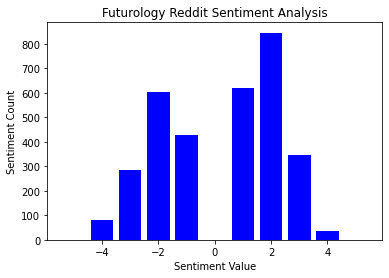

In [28]:
# Count vs Sentiment Value Plot
plt.bar(comment_sentiment_df_2['Sentiment_Value'], comment_sentiment_df_2['Counts'], color='blue')  # add the y-values and color
plt.xlabel('Sentiment Value')  # add x-label
plt.ylabel('Sentiment Count')  # add y-label
plt.title('Futurology Reddit Sentiment Analysis')  # add title
plt.show()

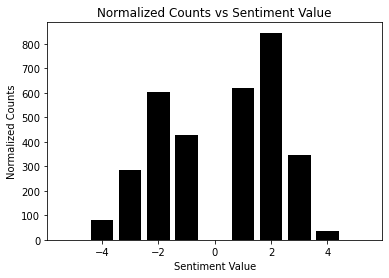

In [29]:
# Normalized Counts vs Sentiment Value Plot
plt.bar(comment_sentiment_df_2['Sentiment_Value'], comment_sentiment_df_2['Counts'], color='black')  # add the y-values and color
plt.xlabel('Sentiment Value')  # add x-label
plt.ylabel('Normalized Counts')  # add y-label
plt.title('Normalized Counts vs Sentiment Value')  # add title
plt.show()

# Prompt
## Now we will overlay the baseline comment sentiment and the subreddit comment sentiment to help compare.

## In each of the three cells below, overlay the plots the Count, Normalized Count, and Normalized Score data vs Sentiment Value. In each plot add the appropriate x-label, y-label, plot title, and plot color

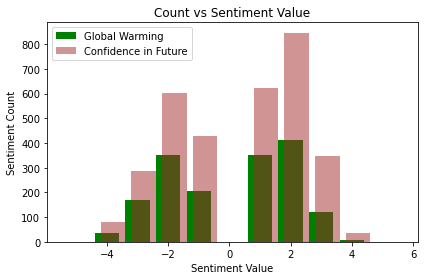

In [38]:
# Count vs Sentiment Value Plot
plt.bar(comment_sentiment_df['Sentiment_Value'], comment_sentiment_df['Counts'], color='green', label='Global Warming')  # add first subreddit data and color

# add second subreddit with a slight offset of x-axis; alpha is opacity/transparency
plt.bar(comment_sentiment_df_2['Sentiment_Value'] + 0.2, comment_sentiment_df_2['Counts'], color='brown', label='Confidence in Future', alpha=0.5)  # add second subreddit and color
plt.legend()  # show the legend

plt.xlabel('Sentiment Value')  # add x-label
plt.ylabel('Sentiment Count')  # add y-label
plt.title('Count vs Sentiment Value')  # add title
plt.tight_layout()  # tight_layout() automatically adjusts margins to make it look nice
plt.show()  # show the plot

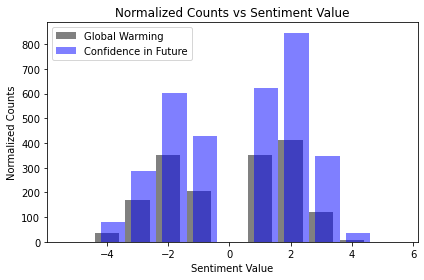

In [39]:
# Normalized Count vs Sentiment Value Plot
plt.bar(comment_sentiment_df['Sentiment_Value'], comment_sentiment_df['Counts'], color='gray', label='Global Warming')  # add first subreddit data and color
ax = plt.gca()  # gets current axes of the plot for adding another dataset to the plot

# add second subreddit with a slight offset of x-axis
plt.bar(comment_sentiment_df_2['Sentiment_Value'] + 0.2, comment_sentiment_df_2['Counts'], color='blue', label='Confidence in Future', alpha=0.5)  # add second subreddit and color
plt.legend()  # show the legend

plt.xlabel('Sentiment Value')  # add x-label
plt.ylabel('Normalized Counts')  # add y-label
plt.title('Normalized Counts vs Sentiment Value')  # add title
plt.tight_layout()  # tight_layout() automatically adjusts margins to make it look nice
plt.show()  # show the plot

# Stretch goal (bonus-ish)
### Although this is not formally a bonus for points, it is a learning opportinity.  You are not required to complete the following part of this notebook for the assignment.

Our sentiment analysis technique above works, but has some shortcomings.  The biggest shortcoming is that each word is treated individually.  But what if we have a sentence with a negation?  For example:

'This is not a bad thing.'

This sentence should be positive overall, but AFINN only has the word 'bad' in the dictionary, and so the sentence gets an overall negative score of -3.

The most accurate sentiment analysis methods use neural networks to capture context as well as semantics.  The drawback of NNs is they are computationally expensive to train and run.

An easier method is to use a slightly-improved sentiment analysis technique, such as TextBlob or VADER (https://github.com/cjhutto/vaderSentiment) in Python.  Both libraries use a hand-coded algorithm with word scores like AFINN, but also with additions like negation rules (e.g. a word after 'not' has it's score reversed).

Other sentiment analysis libraries in Python can be read about here: https://www.iflexion.com/blog/sentiment-analysis-python

### The stretch goal
The stretch goal is to use other sentiment analysis libraries on the Reddit data we collected, and compare the various approaches (AFINN word-by-word, TextBlob, and VADER) using plots and statistics.  For the AFINN word-by-word approach, you will need to either sum up the sentiment scores for each comment, or average them.  You might also divide them by 5 to get the values between -1 and +1.

Here is a brief example of getting scores from the 3 methods described above.  We can see while the raw AFINN approach gives a score of -0.6 (if normalized), TextBlob shows 0.35 and VADER shows 0.43.

In [ ]:
!conda install -c conda-forge textblob

In [ ]:
!pip install textblob vaderSentiment

In [ ]:
sentence = 'This is not a bad thing.'
[(word, scores[word]) for word in sentence.split() if word in scores]

In [ ]:
from textblob import TextBlob
tb = TextBlob(sentence)
print(tb.polarity)
print(tb.sentiment_assessments)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(sentence)